Earth Observation and Computer Vision

Title: Satellite Image Classification

Q1. Spatial Reasoning & Data Download

In [4]:
# Plot the Delhi-NCR shapefile using matplotlib

In [5]:
pip install geopandas matplotlib 

Note: you may need to restart the kernel to use updated packages.


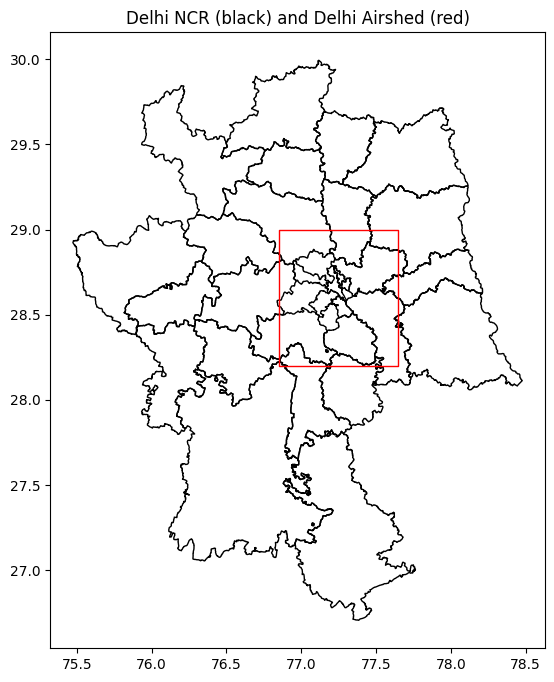

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt


airshed_shp = "delhi_airshed.geojson"
ncr_shp  = "delhi_ncr_region.geojson"

gdf_ncr = gpd.read_file(ncr_shp)
gdf_airshed = gpd.read_file(airshed_shp)

fig, ax = plt.subplots(1,1, figsize=(8,8))
gdf_ncr.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
gdf_airshed.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)
ax.set_title("Delhi NCR (black) and Delhi Airshed (red)")
plt.show()


In [7]:
# Overlay this grid (Delhi Airshed) on a satellite basemap using geemap or leafmap

In [ ]:
pip install geemap earthengine-api folium

Note: you may need to restart the kernel to use updated packages.


In [6]:
import geemap.foliumap as geemap
import geopandas as gpd

m = geemap.Map(center=[28.6,77.2], zoom=9)
m.add_basemap("SATELLITE")

gdf_ncr = gpd.read_file(ncr_shp).to_crs(epsg=4326)
gdf_airshed = gpd.read_file(airshed_shp).to_crs(epsg=4326)

m.add_gdf(gdf_ncr, layer_name="Delhi_NCR", style={"color":"black","fill":False})
m.add_gdf(gdf_airshed, layer_name="Delhi_Airshed", style={"color":"red","fill":False})

m


In [ ]:
# download images

In [ ]:
import geopandas as gpd
import ee
import geemap
from shapely.geometry import box
import numpy as np
import time
import json

In [4]:
#1) Authenticate and initialize Earth Engine

In [2]:
ee.Authenticate()
ee.Initialize()


In [ ]:
# Load Delhi Airshed shapefile

In [ ]:
airshed_gdf = gpd.read_file("delhi_airshed.geojson").to_crs(epsg=32644)

tile_size = 1280  
bounds = airshed_gdf.total_bounds  
xmin, ymin, xmax, ymax = bounds

tiles = []
for x in np.arange(xmin, xmax, tile_size):
    for y in np.arange(ymin, ymax, tile_size):
        tile = box(x, y, x + tile_size, y + tile_size)
        if tile.intersects(airshed_gdf.union_all()):
            centroid = tile.centroid
            centroid_lonlat = gpd.GeoSeries([centroid], crs=airshed_gdf.crs).to_crs(epsg=4326).iloc[0].coords[0]
            tiles.append({'geom': tile, 'center_lonlat': centroid_lonlat})

print(f"Total tiles generated: {len(tiles)}")







In [ ]:
with open("C:\\Users\\neelp\\OneDrive\\Desktop\\bd\\tiles_part1.json", "r") as f:
    tiles_raw = json.load(f)

tiles = []
for t in tiles_raw:
    geom = shapely.wkt.loads(t["geom_wkt"])
    tiles.append({"geom": geom, "center_lonlat": t["center_lonlat"]})

print(f" Loaded {len(tiles)} tiles from JSON")

In [ ]:
with open("C:\\Users\\neelp\\OneDrive\\Desktop\\bd\\tiles_part2.json", "r") as f:
    tiles_raw = json.load(f)

tiles = []
for t in tiles_raw:
    geom = shapely.wkt.loads(t["geom_wkt"])
    tiles.append({"geom": geom, "center_lonlat": t["center_lonlat"]})

print(f" Loaded {len(tiles)} tiles from JSON")

In [ ]:
start_date = '2025-01-01'
end_date = '2025-01-31'

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
)

In [ ]:
# Cloud masking function

In [ ]:
def mask_clouds(img):
    qa = img.select('QA60')  
    return img.updateMask(qa.eq(0))

collection = collection.map(mask_clouds)

In [ ]:
output_folder = 'Delhi_Airshed_Tiles_final'
scale = 10
use_median = False  

batch_size = 250
wait_seconds = 60

Total tiles generated: 4373


In [ ]:
total_tiles = len(tiles)

for i in range(0, total_tiles, batch_size):
    batch_tiles = tiles[i:i + batch_size]
    print(f"\n Submitting tiles {i + 1} to {i + len(batch_tiles)}...")

    for t in batch_tiles:
        center_lon, center_lat = t['center_lonlat']
        
        geom_ee = geemap.geopandas_to_ee(
            gpd.GeoDataFrame({'geometry': [t['geom']]}, crs=airshed_gdf.crs).to_crs(epsg=4326)
        )

        if use_median:
            img = collection.filterBounds(geom_ee).median().select(['B4','B3','B2'])
        else:
            # qualityMosaic picks the clearest pixels based on B4
            img = collection.filterBounds(geom_ee).qualityMosaic('B4').select(['B4','B3','B2'])
        filename = f"tile_{center_lat:.6f}_{center_lon:.6f}"

     
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=filename,
            folder=output_folder,
            fileNamePrefix=filename,
            region=geom_ee.geometry(),
            scale=scale,
            crs='EPSG:32644',
            maxPixels=1e9
        )
        task.start()
        print(f" Started export for {filename}")

    print(f" Batch {i//batch_size + 1} submitted. Waiting {wait_seconds} seconds before next batch...")
    time.sleep(wait_seconds)

print(" All batches submitted! ")


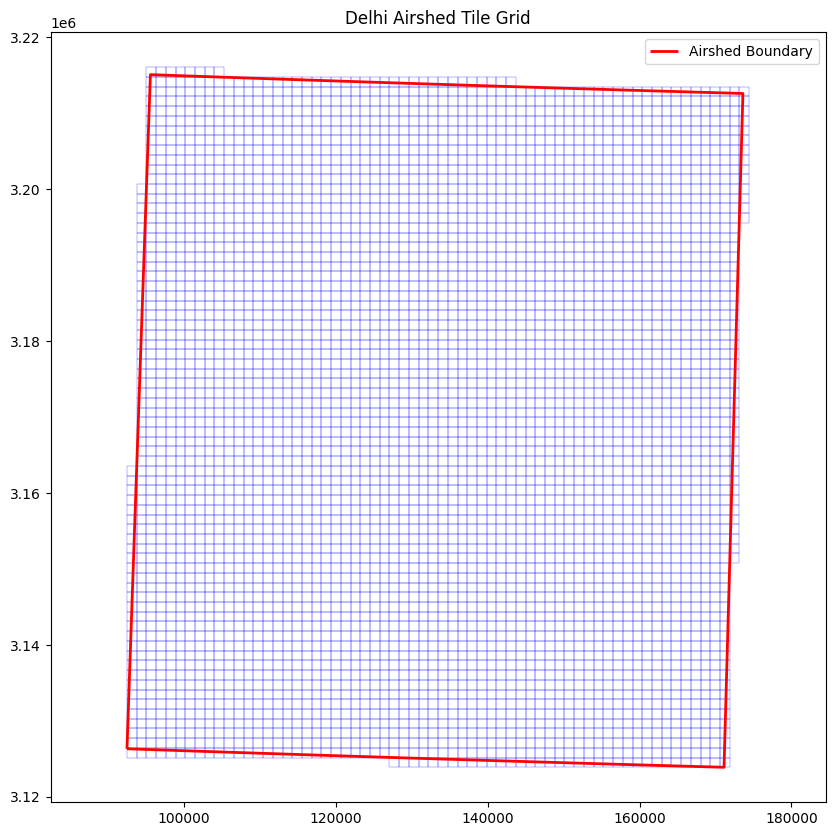

In [14]:
import matplotlib.pyplot as plt


tile_gdf = gpd.GeoDataFrame(
    [t['geom'] for t in tiles], 
    columns=['geometry'], 
    crs=airshed_gdf.crs
)


fig, ax = plt.subplots(figsize=(10, 10))
airshed_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Airshed Boundary')
tile_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.2)

plt.title("Delhi Airshed Tile Grid")
plt.legend()
plt.axis('equal')
plt.show()


In [ ]:
# To confirm successful download of all tiles, you must provide visual plots and the total count of downloaded images.

In [3]:
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from glob import glob
import numpy as np


folder = "Delhi_Airshed_Tiles_2025"


images = glob(os.path.join(folder, "*.tif")) 


print(f" Total downloaded images: {len(images)}")


 Total downloaded images: 4373


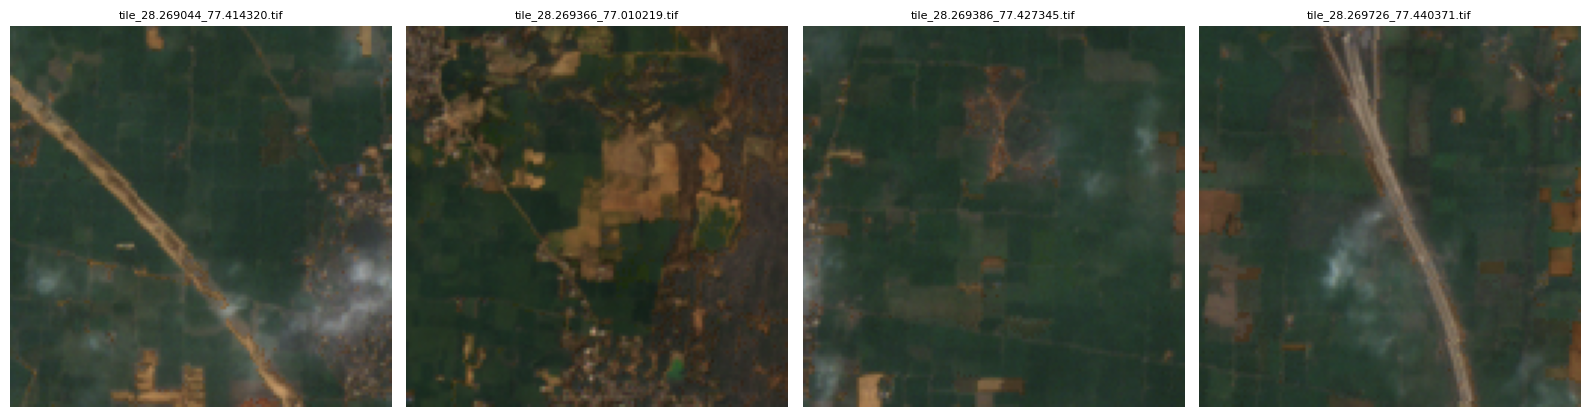

In [4]:
# Pick first 4 to visualize
sample_images = images[400:404]

# Plot each
fig, axes = plt.subplots(1, len(sample_images), figsize=(16, 6))
for ax, img_path in zip(axes, sample_images):
    with rasterio.open(img_path) as src:
        img = src.read([1, 2, 3])  
        img = np.moveaxis(img, 0, -1)  
        
        
        img = np.clip(img, 0, 4000)  
        img = img / 4000.0  
        
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#When downloading satellite imagery, what important parameters should you consider and why?



# ans - when we download satellite imagery, we should consider data, cloud coverage, timing and spatial resolution.

Q2. Label Construction & Dataset Preparation

In [5]:
import rasterio
from rasterio.windows import Window
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re
from collections import Counter

In [6]:
landcover_path = "worldcover_bbox_delhi_ncr_2021.tif"                        
tiles_folder = "Delhi_Airshed_Tiles_2025"              
output_csv = "tile_labels.csv"  

In [7]:
esa_map = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/sparse",
    70: "Snow/Ice",
    80: "Water",
    90: "Wetland",
    95: "Mangroves",
    100: "Moss/Lichen"
}

In [8]:
def parse_coords(filename):
    """Extract lon, lat from filename like tile_<lat>_<lon>.tif"""
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", os.path.basename(filename))
    if len(nums) >= 2:
        lat = float(nums[0])
        lon = float(nums[1])
        return lon, lat
    else:
        return None, None

def compute_mode_label(patch, nodata):
    """Compute most frequent class value ignoring no-data."""
    flat = patch.flatten()
    if nodata is not None:
        flat = flat[flat != nodata]
    flat = flat[~np.isnan(flat)]
    if flat.size == 0:
        return None
    mode_val = Counter(flat.tolist()).most_common(1)[0][0]
    return int(mode_val)

In [9]:
results = []
patch_size = 128

with rasterio.open(landcover_path) as lc:
    nodata = lc.nodata

    for fname in os.listdir(tiles_folder):
        if not fname.endswith(".tif"):
            continue

        fpath = os.path.join(tiles_folder, fname)
        lon, lat = parse_coords(fname)
        if lon is None or lat is None:
            print(f" Skipping {fname}, coords not found.")
            continue

        try:
            col, row = lc.index(lon, lat)
            half = patch_size // 2
            window = Window(col - half, row - half, patch_size, patch_size)

            
            col_off = int(max(0, window.col_off))
            row_off = int(max(0, window.row_off))
            width = int(min(window.width, lc.width - col_off))
            height = int(min(window.height, lc.height - row_off))

            patch = lc.read(1, window=Window(col_off, row_off, width, height))
            mode_code = compute_mode_label(patch, nodata)
            label_name = esa_map.get(mode_code, f"Unknown ({mode_code})") if mode_code else "NoData"

            results.append({
                "filename": fname,
                "longitude": lon,
                "latitude": lat,
                "label_code": mode_code,
                "label_name": label_name
            })

        except Exception as e:
            print(f"Error processing {fname}: {e}")


Error processing tile_28.194235_77.208394.tif: Number of columns or rows must be non-negative
Error processing tile_28.448343_77.656416.tif: Number of columns or rows must be non-negative
Error processing tile_28.459877_77.656053.tif: Number of columns or rows must be non-negative
Error processing tile_28.471411_77.655689.tif: Number of columns or rows must be non-negative
Error processing tile_28.852359_77.656673.tif: Number of columns or rows must be non-negative
Error processing tile_28.863893_77.656303.tif: Number of columns or rows must be non-negative
Error processing tile_28.875426_77.655933.tif: Number of columns or rows must be non-negative
Error processing tile_28.886960_77.655564.tif: Number of columns or rows must be non-negative


 Saved 4365 labeled tiles to tile_labels.csv


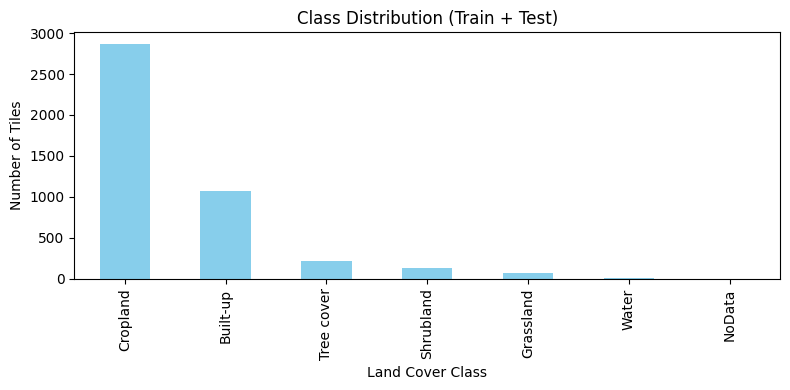

In [10]:
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f" Saved {len(df)} labeled tiles to {output_csv}")


plt.figure(figsize=(8, 4))
df["label_name"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Class Distribution (Train + Test)")
plt.xlabel("Land Cover Class")
plt.ylabel("Number of Tiles")
plt.tight_layout()
plt.show()

Q3. Model Training & Supervised Evaluation

In [ ]:
# Train a CNN classifier (e.g., ResNet18) on the training set

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score
from torchmetrics.classification import MulticlassF1Score
import random, os


In [12]:
# Paths
tiles_folder = "Delhi_Airshed_Tiles_2025"
labels_csv = "tile_labels.csv"

df = pd.read_csv(labels_csv)
df = df[df["label_name"] != "NoData"]  # drop unlabeled
classes = sorted(df["label_name"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}


import rasterio
from torchvision.transforms.functional import to_pil_image

class LandCoverDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(tiles_folder, row["filename"])
        label = class_to_idx[row["label_name"]]

        
        if img_path.lower().endswith(".tif"):
            with rasterio.open(img_path) as src:
                img = src.read([1, 2, 3])  # Use RGB bands
                img = np.clip(img, 0, 10000) / 10000.0  # Normalize 0–1
                img = torch.tensor(img, dtype=torch.float32)
                img = to_pil_image(img)
        else:
            img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        return img, label



train_df = df.sample(frac=0.6, random_state=42)
test_df = df.drop(train_df.index)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_ds = LandCoverDataset(train_df, transform)
test_ds = LandCoverDataset(test_df, transform)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

print(" Dataset ready:")
print(f"Train: {len(train_ds)}, Test: {len(test_ds)}, Classes: {len(classes)}")


 Dataset ready:
Train: 2618, Test: 1746, Classes: 6


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dl):.4f}")


Epoch 1/5, Loss: 1.0797
Epoch 2/5, Loss: 0.3907
Epoch 3/5, Loss: 0.1287
Epoch 4/5, Loss: 0.0492
Epoch 5/5, Loss: 0.0234


In [ ]:
# Evaluate using a custom F1 score implementation

In [14]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


custom_f1 = f1_score(all_labels, all_preds, average="macro")
print(f" Custom F1 Score (macro): {custom_f1:.4f}")




 Custom F1 Score (macro): 0.3069


In [ ]:
# Evaluate using torchmetrics.F1Score and compare results

In [15]:

f1_metric = MulticlassF1Score(num_classes=len(classes), average="macro").to(device)
torch_f1 = f1_metric(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
print(f" TorchMetrics F1 Score: {torch_f1.item():.4f}")

 TorchMetrics F1 Score: 0.3069


In [ ]:
# Show and explain a confusion matrix

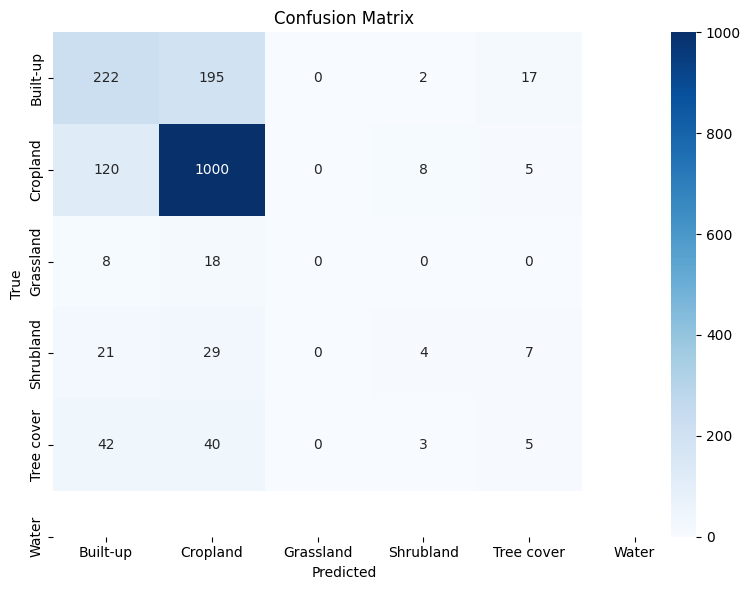

In [16]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
#Plot 5 correct and 5 incorrect predictions with images and labels

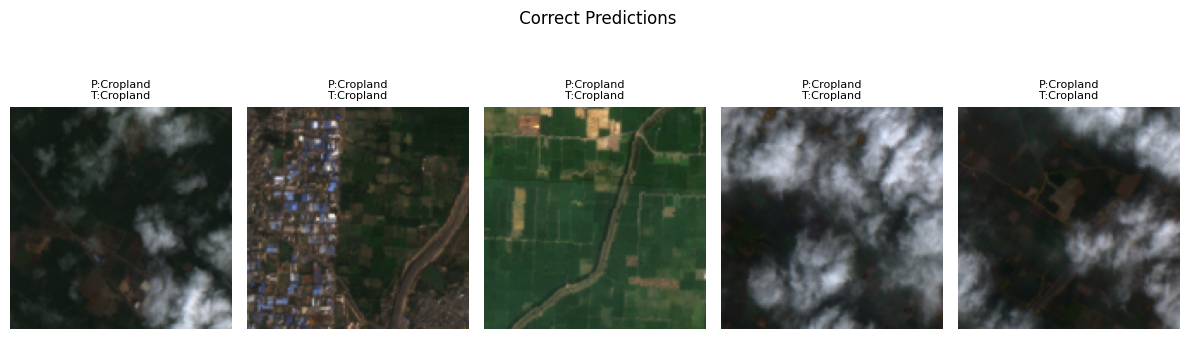

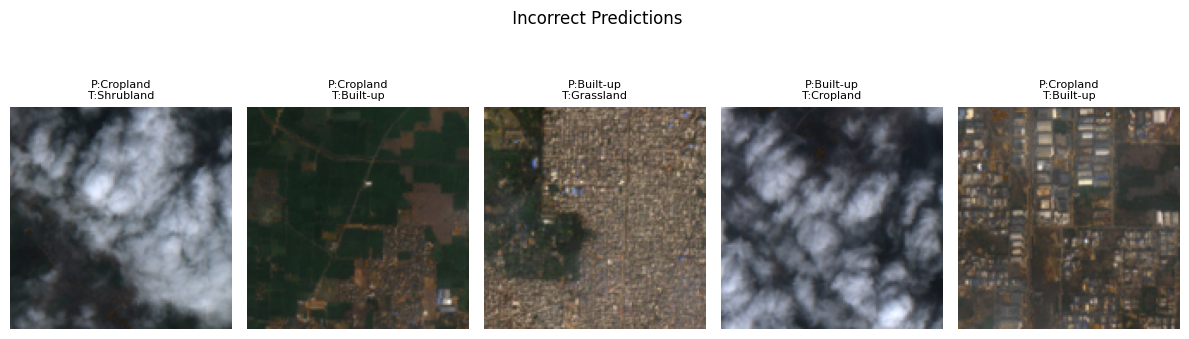

In [17]:

import rasterio
from PIL import Image
correct, incorrect = [], []

for i, (pred, true) in enumerate(zip(all_preds, all_labels)):
    if pred == true:
        correct.append(i)
    else:
        incorrect.append(i)

sample_correct = random.sample(correct, min(5, len(correct)))
sample_incorrect = random.sample(incorrect, min(5, len(incorrect)))


def show_samples(indices, title):
    plt.figure(figsize=(12, 4))
    for j, i in enumerate(indices):
        row = test_df.iloc[i]
        img_path = os.path.join(tiles_folder, row["filename"])

       
        if img_path.lower().endswith(".tif"):
            with rasterio.open(img_path) as src:
                img = src.read([1, 2, 3])
                img = np.clip(img, 0, 10000)
                img = (img / img.max() * 255).astype(np.uint8)
                img = np.transpose(img, (1, 2, 0))  # (H, W, C)
        else:
            img = np.array(Image.open(img_path).convert("RGB"))

        plt.subplot(1, len(indices), j + 1)
        plt.imshow(img)
        plt.axis("off")

        pred_label = classes[all_preds[i]]
        true_label = classes[all_labels[i]]
        plt.title(f"P:{pred_label}\nT:{true_label}", fontsize=8)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


show_samples(sample_correct, " Correct Predictions")
show_samples(sample_incorrect, " Incorrect Predictions")


c:\Users\neelp\anaconda3\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (92179200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


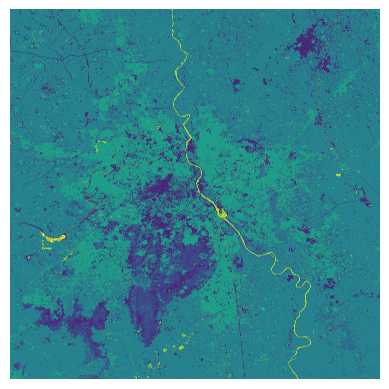

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('worldcover_bbox_delhi_ncr_2021.tif')  

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes (optional)
plt.show()
